# 数据挖掘第二次编程作业--推荐系统
---

In [1]:
from __future__ import print_function
import cPickle
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import math
import random
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.porter import PorterStemmer
import codecs

%matplotlib inline

DATA_FILE = "./data/train.dat"
PKL_FILE = "./data/df.pkl"
RENEWED_FNAME = "./data/renewed-train.dat"

## 1. 数据预处理分析

为大致了解数据，先对数据做简要处理。

提取出数据的前三列，即`usr id`，`item id`和`rating`数据，并存入单独文件，为便于后续处理。另外，考虑到如果时间有限，可以依据此文件做基础的基于评分数据的推荐，而忽略评论数据。

In [2]:
def get_ratings_into_file(src_fname, dst_fname):
    """ 将训练数据的前三列，即用户id，物品id和评分提取出来，存入目标文件 """
    outf = open(dst_fname, 'a+')
    with open(src_fname, 'r') as inf:
        for line in inf.readlines():
            items = line.split(" ")[:3]
            newLine = ""
            for i in items:
                newLine += (i + " ")
            newLine.strip()
            newLine += '\n'
            outf.write(newLine)
    outf.close()

In [3]:
def load(fname):
    """ 将文件数据导入pandas.DataFrame。
    如果首次导入，则将此dataFrame存入同名pkl文件，方便后续调用；如果同名pkl文件存在，则直接从此pkl文件中导入。
    """
    pkl_fname = ".{}.pkl".format(fname.split(".")[-2])
    
    if not os.path.exists(pkl_fname):
        df = pd.read_csv(fname, sep="\s+", header=None)
        df.columns = ["User", "Item", "Rating"]
        
        with open(pkl_fname, 'wb') as pklf:
            cPickle.dump(df, pklf)
    else:
        with open(pkl_fname, 'r') as pklf:
            df = cPickle.load(pklf)
            
    return df

In [4]:
df = load(RENEWED_FNAME)

usrs = pd.value_counts(df.User)
items = pd.value_counts(df.Item)

print("In 'train.dat', {} users and {} items in total.".format(usrs.size, items.size))

In 'train.dat', 21443 users and 16610 items in total.


In [5]:
usrs.describe()

count    21443.000000
mean        18.344728
std         19.736327
min          2.000000
25%          9.000000
50%         12.000000
75%         20.000000
max        562.000000
Name: User, dtype: float64

In [6]:
items.describe()

count    16610.000000
mean        23.682480
std         27.098671
min          4.000000
25%         10.000000
50%         15.000000
75%         26.000000
max        533.000000
Name: Item, dtype: float64

经过上述处理，可以看到训练数据中，一共有21443个用户，和16610个物品，二者在量级上一致。于是，如果构建用户-物品矩阵，此矩阵维度将是 $21443\times16610$ 。

**另外，可以看到75%的用户只评论了至多20个物品；而75%的物品只被至多26个用户同时评论。**已经可以认为服从长尾分布，下面从分布图上进一步证实这一点。

以下，绘制训练数据中，用户出现次数的分布图以及物品出现次数的分布图。

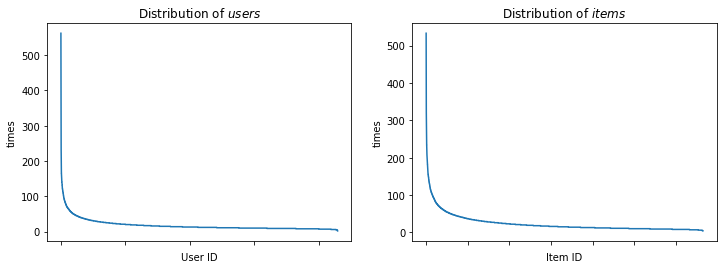

In [7]:
plt.subplot(1, 2, 1)
usrs.plot.line(figsize=(12, 4))
plt.xlabel("User ID")
plt.ylabel("times")
plt.title(r"Distribution of $users$")

plt.subplot(1, 2, 2)
items.plot.line(figsize=(12, 4))
plt.xlabel("Item ID")
plt.ylabel("times")
plt.title(r"Distribution of $items$")

plt.show()

由以上图，可以发现无论是用户，还是物品，都是符合长尾分布（也，[齐夫分布](https://en.wikipedia.org/wiki/Zipf%27s_law)）。

In [8]:
def RSME(r, r_hat):
    """ 计算均方根误差 """
    assert r.size == r_hat.size
    
    error = 0.0
    for i, j in zip(r, r_hat):
        error += (i - j) ** 2
    error = math.sqrt(error) / r.size
    
    return error 

## 2. Simon Funk的SVD分解

参考：[Simon Funk's Blog](http://sifter.org/~simon/journal/20061211.html)

对用户-物品矩阵 $R$ 分解到低维空间上的两矩阵 $P$ 和 $Q$ 相乘。

$$\hat{R} = P^\text{T}Q$$

则，对于用户 $u$ 对物品 $i$ 的评分预测可表示为：

$$\hat{r}=\sum_f p_{uf}q_{if}$$

利用训练集最小化RSME来学习矩阵 $P$ 和 $Q$ ：

$$\min C(P, Q) = \min_{p,q}\sum_{(u,i)\in Train}\left( r_{ui}-\sum_{f=1}^F p_{uf}q_{if} \right)^2 + \lambda\left( \lVert p_u \rVert^2 + \lVert q_i \rVert^2\right)$$

利用随机梯度下降法（SGD）求解上述最优化问题，有
$$\frac{\partial C}{\partial p_{uf}} = -2\left(r_{ui}-\hat{r}_{ui}\right)q_{if}+2\lambda p_{uf}$$

$$\frac{\partial C}{\partial q_{if}} = -2\left(r_{ui}-\hat{r}_{ui}\right)p_{uf}+2\lambda q_{if}$$

于是，有如下更新公式：
$$p_{uf} =: p_{uf} + \alpha \left(\left(r_{ui}-\hat{r}_{ui}\right)q_{if} - \lambda p_{uf}\right)$$

$$q_{if} =: q_{if} + \alpha\left(\left(r_{ui}-\hat{r}_{ui}\right) p_{uf} - \lambda q_{if}\right)$$

以上算法被称之为**L**atent **F**actor **M**odel（LFM）

In [ ]:
def predict(u, i, p, q):
    """ 预测用户 u 在物品 i 上的评分 """
    sum = 0.0
    for f in range(len(p[u])):
        sum += p[u][f] * q[i][f]
    return sum
#     return sum(p[u][f] * q[i][f] for f in range(len(p[u])))

In [ ]:
def init_LFM(train, F):
    """初始化参数 p 和 q，据《推荐系统实践》：“，根据经验，随机数需要和1 / sqrt(F)成正比“ """
    p = dict()
    q = dict()

    for index in range(train.count()[0]):
        u, i, rating = list(train.values[index])
        if u not in p:
            p[u] = [random.random() / math.sqrt(F) for f in range(F)]
        if i not in q:
            q[i] = [random.random() / math.sqrt(F) for f in range(F)]
    return p, q

In [ ]:
def learn_LFM(train, F, n, alpha=0.001, lamb=0.02):
    """ 学习隐语义模型参数 """
    p, q = init_LFM(train, F)

    for step in range(n):
        for index in range(train.count()[0]):
            u, i, rui = list(train.values[index])
            
            rui_hat = predict(u, i, p, q)
            eui =  rui - rui_hat
            for f in range(F):
                p[u][f] += alpha * (eui * q[i][f] - lamb * p[u][f])
                q[i][f] += alpha * (eui * p[u][f] - lamb * q[i][f])
        # end for
        alpha *= 0.9     # the requirement of SGD method
    # end for
    return p, q

In [ ]:
small_data = load("./data/small-renewed-train.dat")

In [ ]:
small_data = small_data.iloc[:, :3]

p, q = learn_LFM(small_data, 10, 2000, 0.001, 0.02)

In [ ]:
small_data = small_data.iloc[:, :3]
prediction = []
for index in range(small_data.count()[0]):
    u, i, rui = list(small_data.values[index])
    rui_hat = int(round(predict(u, i, p, q)))
    if rui_hat > 5:
        rui_hat = 5
    prediction.append(rui_hat)
small_data["Prediction"] = prediction

In [ ]:
small_data.head(20)

In [ ]:
error = RSME(small_data["Rating"], small_data["Prediction"])
error


## 3.加入偏置项后的LFM

此处参考「3」。

预测公式：

$$\hat{r}_{ui} = \mu + b_u + b_i + p_u^\text{T}q_i$$

其中：

- $\mu$ 是训练集中所有记录的评分的全局平均数；
- $b_u$ 为用户偏置项；
- $b_i$ 为物品偏置项。

于是，描述为如下最优化问题：

$$\min C(P, Q) = \min_{p,q}\sum_{(u,i)\in Train}\left( r_{ui}- \mu - b_u - b_i - \sum_{f=1}^F p_{uf}q_{if} \right)^2 + \lambda_1\left( \lVert p_u \rVert^2 + \lVert q_i \rVert^2\right) + \lambda_2\left(\lVert b_u \rVert^2 + \lVert b_i \rVert^2\right)$$

此处，为了简便，取 $\lambda_1=\lambda_2=\lambda$ ，同样，利用**SGD**可以得出如下偏导：

$$\frac{\partial C}{\partial b_u} = -2\left(r_{ui} - \hat{r}_{ui}\right)+2\lambda_2 b_u
\qquad
\frac{\partial C}{\partial b_i} = -2\left(r_{ui} - \hat{r}_{ui}\right)+2\lambda_2 b_i$$

$$\frac{\partial C}{\partial p_{uf}} = -2\left(r_{ui}-\hat{r}_{ui}\right)q_{if}+2\lambda_1 p_{uf}
\qquad
\frac{\partial C}{\partial q_{if}} = -2\left(r_{ui}-\hat{r}_{ui}\right)p_{uf}+2\lambda_1 q_{if}$$

与更新公式:

$$b_u =: b_u + \alpha \left(\left(r_{ui} - \hat{r}_{ui}\right) - \lambda_2 b_u\right)
\qquad
b_i =: b_i + \alpha \left(\left(r_{ui} - \hat{r}_{ui}\right) - \lambda_2 b_i\right)$$

$$p_{uf} =: p_{uf} + \alpha \left(\left(r_{ui}-\hat{r}_{ui}\right)q_{if} - \lambda_1 p_{uf}\right)
\qquad
q_{if} =: q_{if} + \alpha\left(\left(r_{ui}-\hat{r}_{ui}\right) p_{uf} - \lambda_1 q_{if}\right)$$

In [ ]:
avg_rating = int(round(small_data["Rating"].sum()*1.0 / small_data["Rating"].count()))
avg_rating       # mu

In [ ]:
def learn_bias_LFM(train, F, n, alpha, lamb, mu):
    """ 学习带有偏置量的LFM模型 """
    bu, bi, p, q = init_bias_LFM(train, F)
    for step in range(n):
        for index in range(train.count()[0]):
            u, i, rui = list(train.values[index])
            rui_hat = predict_bias(u, i, p, q, bu, bi, mu)
            eui = rui - rui_hat
            
            # updating parameters 
            bu[u] += alpha * (eui - lamb * bu[u])
            bi[i] += alpha * (eui - lamb * bi[i])
            for f in range(F):
                p[u][f] += alpha * (q[i][f] * eui - lamb * p[u][f])
                q[i][f] += alpha * (p[u][f] * eui - lamb * q[i][f])
        # end for
        alpha *= 0.9
    # end for
    return bu, bi, p, q

In [ ]:
def init_bias_LFM(train, F):
    """ 初始化带偏置量的LFM模型里的偏置参数和隐变量参数 """
    p = dict()
    q = dict()
    bu = dict()
    bi = dict()
    
    for index in range(train.count()[0]):
        u, i, rui = list(train.values[index])
        bu[u] = 0
        bi[i] = 0
        if u not in p:
            p[u] = [random.random() / math.sqrt(F) for f in range(F)]
        if i not in q:
            q[i] = [random.random() / math.sqrt(F) for f in range(F)]
    # end for
    
    return bu, bi, p, q

In [ ]:
def predict_bias(u, i, p, q, bu, bi, mu):
    """ 运用带偏置量的模型进行预测 """
    prediction = mu + bu[u] + bi[i]
    for f in range(len(p[u])):
        prediction += p[u][f] * q[i][f]
    return prediction

In [ ]:
small_data = small_data.iloc[:, :3]

bu, bi, p, q = learn_bias_LFM(small_data, 6, 1000, 0.001, 0.02, avg_rating)

In [ ]:
prediction = []
for index in range(small_data.count()[0]):
    u, i, rui = list(small_data.values[index])
    result = predict_bias(u, i, p, q, bu, bi, avg_rating)
    rui_hat = int(round(result))
    if rui_hat > 5:
        rui_hat = 5
    prediction.append(rui_hat)
small_data["Prediction"] = prediction


In [ ]:
small_data.head(20)

In [ ]:
error = RSME(small_data["Rating"], small_data["Prediction"])
error

## 4.考虑带评论信息的LFM

当考虑到评论信息时，可以认为：关于物品 $i$ 的全部评论可以刻画此物品的特征。于是，可对下式中的 $q_i$ 做替换：

$$\hat{r}_{ui} = \mu + b_u + b_i + p_u^\text{T}q_i$$

将评论考虑在内：(此处参考论文「1」)

$$\hat{r}_{ui} = \mu + b_u + b_i + p_u^\text{T}\left(\frac{1}{\lvert R_i\rvert} \sum_{w\in R_i}q_w\right)$$

其中，$R_i$ 关于物品 $i$ 的所有评论的词集，$q_w$ 则是关于词 $w$的隐语义(latent factors)向量。另外，最优化问题变为：

$$\min_{p,q}\sum_{(u,i)\in Train}\left( r_{ui}- \mu - b_u - b_i - p_u^\text{T}\left(\frac{1}{\lvert R_i\rvert} \sum_{w\in R_i}q_w\right) \right)^2 + \lambda_1\left( \lVert p_u \rVert^2 + \sum_{w\in R_i}\lVert q_w \rVert^2\right) + \lambda_2\left(\lVert b_u \rVert^2 + \lVert b_i \rVert^2\right)$$

同样，使用SGD迭代求解上述最优化问题，有关于 $p_u$ 和 $q_w$ 的更新公式：（其他参数的更新公式同上节）


$$p_u =: p_u + \alpha \cdot \left( \left( r_{ui} - \hat{r}_{ui}\right) \cdot \frac{1}{\lvert R_i\rvert}\sum_{w\in R_i}q_w-\lambda_1p_u\right)$$
$$q_w =: q_w + \alpha \cdot\left( \left(r_{ui} - \hat{r}_{ui}\right)\cdot\frac{1}{\lvert R_i \rvert}\cdot p_u-\lambda_1 q_w\right)$$

另外，在上海交通大学的论文「2」中，采用 $\frac{1}{Z}\sum_{w\in R_i}q_w$ 替换 $\frac{1}{\lvert R_i\rvert} \sum_{w\in R_i}q_w$ 。

$$\hat{r}_{ui} = \mu + b_u + b_i + p_u^\text{T}\left(\frac{1}{Z}\sum_{w\in R_i}q_w\right)$$

其中论文作者的参考取值为，$q_w\in\mathbb{R}^{200}$, $Z = \sqrt{\lvert R_i\rvert}$ 。

In [ ]:
line = """Ji9PeffxjwqPLO7pEfSpKQ jQsNFOzDpxPmOurSWCg1vQ 3 328 i'm not saying pei wei is the best asian food i've ever tasted far from it it's a 
fairly large chain that puts on the appearance of something more refined it's essentially to asian food what olive garden is to italian 
food with that said i've always had pretty good experiences with pei wei the food although not spectacular is better than some of the 
overcooked chicken drowning in msg offered by some of the local chinese restaurants the portions are good sized the food is generally 
consistent and the prices are really reasonable considering this is a corporate chain in some cases cheaper than the local establishments 
or dare i say it's name panda express which is overpriced crap the time before last that i went they forgot the tomato's and the dressing
for an asian chopped chicken salad that my wife ordered i didn't discover that the dressing was missing until i got home i immediately called 
the restaurant and was speaking to a manager within 30 seconds the manager apologized and asked me if i would like to come back to the restaurant
or if he could have my address so he could send me a gift certificate i decided to go back to the restaurant when i got the restaurant i told the 
person at the counter my name and they already had a bag set aside for me the manager came over and explained to me there was another full salad 
in the bag and he put additional dressing for the salad we already had and additionally he gave me a coupon for free lettuce wraps which mental note 
i need to use i must say i was impressed with this manager and it was refreshing after being in situations where a manager has taken back the bag
plate and essentially k's your food and returns it to you overall great customer service consistent food and a good option for takeout in surprise"""
metas = line.split(" ")
item = metas[1]
review_cnt = metas[3]
review = metas[4:]

print(item)
print(review_cnt)
print(review[:20])

In [ ]:
def load_reviews(fname):
    """ 将所有评论数据导入，为每个物品构建评论词集，不考虑词频和词序，
    使用nltk库去除停用词和标点符号，并且对词进行词干化处理
    @param:
        fname:          string, 训练数据集文件名
    @return:
        train:          DataFrame, 训练数据集
        reviews:        dict, 每个物品对应的评论词集
    """

    print("loading training data")
    punctuations = {',', '.', ':', ';', '?', '(', ')', '[', ']', '!', '@', '#', '%', '$', '*'} # 自定义英文表单符号集合
    english_stopwords = set(stopwords.words("english"))
    tokenizer = WordPunctTokenizer()
    stemmer = PorterStemmer()      # 词干化处理

    reviews = dict()
    review_list = []
    fuir = PREFIX + "u-i-r.dat"
    if not os.path.exists(fuir):
        save_uir = True
        dstf = codecs.open(fuir, mode="a+", encoding="utf-8")
    else:
        save_uir = False

    with codecs.open(fname, mode='r', encoding='utf-8') as f:
        line = f.readline()
        line_no = 0
        while line:
            metas = line.split(" ")

            # 将所有(usr, item, rating)条目存为单独文件，以备基础LFM使用
            if save_uir:
                new_line = ""
                for i in metas[:3]:
                    new_line += (i + " ")
                new_line = new_line.strip()
                dstf.write(new_line + BR)

            item = metas[1]    # item id
            review_str = ""
            for word in metas[4:]:
                review_str += word + " "
            wordset = {stemmer.stem(word) for word in tokenizer.tokenize(review_str)} \
                         - punctuations - english_stopwords

            if wordset:
                review_list.append(wordset)
            else:
                review_list.append(set())

            if item not in reviews:
                reviews[item] = wordset
            else:
                reviews[item].update(wordset)

            line_no += 1
            if line_no % 1000 == 0:
                # print(".", end="")
                print("{} entries hanled.".format(line_no))
            line = f.readline()
        # end while
    # end with
    if save_uir:
        dstf.close()

    train = load(fuir)
    train["Review"] = review_list

    with open(PREFIX + "train.pkl", 'wb') as ftrain:
        cPickle.dump(train, ftrain)

    with open(PREFIX + "review.pkl", "wb") as freview:
        cPickle.dump(reviews, freview)

    return train, reviews


In [ ]:
fname = "./data/small-train.dat"

reviews, review_list= load_reviews(fname)

print(len(reviews))
print(len(review_list))

In [ ]:
dictionary = set()
for review in review_list:
    dictionary.update(review)
    
print("length of review dictionary = {}.".format(len(dictionary)))

In [ ]:
def init_bias_LFM_with_reviews(train, dictionary, F):
    """ 初始化 考虑评论与偏置项的LFM模型 """
    p = dict()
    q = dict()
    bu = dict()
    bi = dict()
    
    for word in dictionary:
        q[word] = [random.random() / math.sqrt(F) for f in range(F)]
    
    for index in range(train.count()[0]):
        u, i = train.values[index][:2]
        bu[u] = 0
        bi[i] = 0
        if u not in p:
            p[u] = [random.random() / math.sqrt(F) for f in range(F)]
    return p, q, bu, bi

In [ ]:
def predict_bias_LFM_with_reviews(u, i, words, F, p, q, bu, bi, mu):
    """ 考虑评论与偏置项的LFM的预测函数，其中：
    
    u        用户id
    i        物品id
    words    物品i对应的评论词集
    F        隐向量的维度
    p        已训练完成的用户向量字典
    q        已训练完成的词向量字典
    bu       已训练完成的用户偏置量
    bi       已训练完成的物品偏置量
    mu       全局评分平均值
    
    """
    prediction = mu + bu[u] + bi[i]
    
    q_total = [0] * F
    for word in words:
        q_total = [i + j / math.sqrt(len(words)) for i, j in zip(q_total, q[word])]
    
    for f in range(F)4031:
        prediction += p[u][f] * q_total[f]
    
    return prediction  

In [ ]:
def learn_bias_LFM_with_reviews(train, reviews, dictionary, F, n, alpha, lambda1, lambda2, mu):
    """ 学习考虑评论与偏置项的LFM模型，其中：
    
        train                训练数据，一个条目为(usr_id, item_id, rating, review)
        reviews              以item_id为索引的字典，存储关于当前物品的全部评论信息
        F                    隐向量的维度
        n                    SGD迭代次数
        alpha                SGD参数
        lambda1, lambda2     对于偏置项的正则化参数
        mu                   全局评分平均值
    
    """
    p, q, bu, bi = init_bias_LFM_with_review(train, dictionary, F)
    for iter in range(n):
        for index in range(train.count()[0]):
            u, i, rui, review_words = train.values[index]

            rui_hat = predict_bias_LFM_with_reviews(u, i, reviews[i], F, p, q, bu, bi, mu)

            eui = rui - rui_hat

            # bu and bi
            bu[u] += alpha * (eui - lambda2 * bu[u])
            bi[i] += alpha * (eui - lambda2 * bi[i])

            # updating p_u
            q_total = [0] * F
            Z = math.sqrt(len(review_words))
            for word in review_words:
                q_total = [i + j for i, j in zip(q_total, q[word])]
            q_total = [i / Z for i in q_total]

            for f in range(F):
                p[u][f] += alpha * (q_total[f] * eui - lambda1 * p[u][f])
            
            # updating q_w
            for word in review_words:
                for f in range(F):
                    q[word][f] += alpha * (p[u][f] * eui / Z - lambda1 * q[word][f])
        # end for
        alpha *= 0.9
    # end for
    return p, q, bu, bi

## 5.参数设置
根据论文「1」中参数设置，做如下参考设置

隐变量维度：$$F=20$$

正则化参数：$$\lambda_1=0.8\quad\lambda_2=0.4$$

学习率：$$\alpha=0.008$$
```python

class LFMWithReview(object):
    """ 将评论数据考虑在内的LFM模型 """
    def __init__(self, F=20, n=2000, alpha=0.008, lambda1=0.8, lambda2=0.4):
        ……
```

## 6.python版本实验结果

将以上考虑评论信息的LFM模型整理，并在完整的训练数据集上运行（代码见`LFM_with_review.py`）。有如下实验结果：

### 6.0在small-train数据上的运行测试
为测试模型的可运行性以及检测代码是否存在bug，先在小数据集（104条训练数据）上运行，结果如下：
>loading training data<br>
dictionary loaded / dumped.<br>
dictionary word vectors initialized.<br>
bias vectors and user vectors initialized.<br>
global average rating: 3.53846<br>
initialization time: 0.07s<br>
iteration 0, Duration: 0.43s<br>
iteration 1, Duration: 0.43s<br>
iteration 2, Duration: 0.43s<br>
iteration 3, Duration: 0.43s<br>
……<br>
iteration 198, Duration: 0.43s<br>
iteration 199, Duration: 0.43s<br>
learning total time: 88.61s<br>
model dumped.<br>
======learning finished.=======<br>
model loaded.<br>
==================================================<br>
precision = 37/100 = 0.37

其中，模型对训练数据的拟合准确率（模型预测值与真实值相同）达到37%。

以下，开始在完整数据集上运行：

### 6.1加载数据与初始化过程
>加载训练数据集用时: 114.985569954s<br>
>加载评论数据用时: 28.175755024s<br>
>dictionary loaded / dumped.<br>
>词集隐向量初始化用时: 5.87744188309s(about 0.0016326227453h)<br>
>偏置量向量与用户向量初始化用时: 31873.5920711s(about 8.85377557529h)<br>
>global average rating: 3.76204<br>
>initialization time: 31879.55s

其中，以上运行结果中，加载训练数据与加载评论数据用时为加载序列化对象用时。运行前，已将训练集的文本文件导入到DataFrame格式中，将各物品对应评论词集导入到dict格式，并存储为序列化文件，其用时大致为6小时。

### 6.2 训练模型过程
>`feng@RS-ubuntu:~/rs$ stdbuf -o0 python LFM_with_reviews.py > final.log &`<br>
>`feng@RS-ubuntu:~/rs$ cat final.log`<br>
>加载训练数据集用时: 116.260338068<br>
>加载评论数据用时: 28.2748670578<br>
>dictionary loaded / dumped.<br>
>词集隐向量初始化用时: 5.87294006348s(about 0.00163137223985h)<br>
>偏置量向量与用户向量初始化用时: 1.14972901344s(about 0.000319369170401h)<br>
>global average rating: 3.76204<br>
>initialization time: 7.09s<br>
>iteration 0, Duration: **42027.59s**<br>
>`feng@RS-ubuntu:~/rs$ kill 120311`

其中，以上运行结果中，加载与初始化过程都是加载上一次运行时保存的序列化对象文件，故而用时较短。但当程序完成第一次迭代后，选择终止了程序的运行。因为第一次迭代用时大致为42000秒，也就是近12小时。完成一次迭代即需要12小时，模型参数中设置迭代次数为200次，则需要100天。被迫选择中止运行。

CPU占用情况：（2核16内存微软Azure云平台Ubuntu虚拟机）
![CPU占用情况](./cpu.png)

## 7.C++版本运行结果
由于上述python语言各方法时间复杂度太高，无法在合理时间内运行出结果。故转而求助于C++语言，将只考虑偏置项而不考虑评论的LFM模型改写为C++语言运行。结果大致如下：

C++语言版本见具体目录文件，此处不再列出。

### 7.1参数设置为：`n = 50, alpha = 0.08, lambda = 0.8`时：

>	MSE: 1.13612	
Iteration 0, time cost: 100	MSE: 1.04631	
Iteration 1, time cost: 100	MSE: 1.03089	
Iteration 2, time cost: 98	MSE: 1.02222	
Iteration 3, time cost: 98	MSE: 1.01525	
Iteration 4, time cost: 98	MSE: 1.00906	
Iteration 5, time cost: 98	MSE: 1.00342<br>
……<br>
Iteration 44, time cost: 98	MSE: 0.94367	
Iteration 45, time cost: 98	MSE: 0.943546	
Iteration 46, time cost: 98	MSE: 0.943434	
Iteration 47, time cost: 97	MSE: 0.943333	
Iteration 48, time cost: 98	MSE: 0.943242	
Iteration 49, time cost: 98	MSE: 0.942418<br>
Learning time cost: 4907s.

迭代次数为50次，每次迭代耗时为100s左右，MSE随迭代次数逐渐下降。

### 7.2参数设置为：`n = 20, alpha = 0.18, lambda = 0.8`时：
>	MSE: 1.17838	
Iteration 0, time cost: 98s,	MSE: 1.12607	
Iteration 1, time cost: 97s,	MSE: 1.1099	
Iteration 2, time cost: 97s,	MSE: 1.09597	
Iteration 3, time cost: 96s,	MSE: 1.08332	
Iteration 4, time cost: 97s,	MSE: 1.07179	
……<br>
Iteration 16, time cost: 97s,	MSE: 0.987829	
Iteration 17, time cost: 97s,	MSE: 0.983851	
Iteration 18, time cost: 97s,	MSE: 0.980191	
Iteration 19, time cost: 96s,	MSE: 0.945461<br>
Learning time cost: 1940s.

### 7.3参数设置为：`n = 100, alpha = 0.25, lambda = 0.08`时：
>Iteration 0, time cost: 98s,	MSE: 1.18943	
Iteration 1, time cost: 97s,	MSE: 1.1653	
Iteration 2, time cost: 97s,	MSE: 1.1449	
Iteration 3, time cost: 97s,	MSE: 1.12712	
Iteration 4, time cost: 97s,	MSE: 1.11139	
Iteration 5, time cost: 97s,	MSE: 1.09728	
Iteration 6, time cost: 97s,	MSE: 1.08452	
Iteration 7, time cost: 98s,	MSE: 1.07291<br>	
……<br>
Iteration 96, time cost: 97s,	MSE: 0.942441	
Iteration 97, time cost: 97s,	MSE: 0.942439	
Iteration 98, time cost: 98s,	MSE: 0.942437	
Iteration 99, time cost: 98s,	MSE: 0.942422<br>
Learning time cost: 9772s.

可见，MSE由1.18943下降到0.942422。
### 7.4参数设置为：`n = 200, alpha = 0.17, lambda = 0.08`时：
>Iteration 0, time cost: 98s,	MSE: 1.11749	
Iteration 1, time cost: 99s,	MSE: 1.10209	
Iteration 2, time cost: 98s,	MSE: 1.08891	
Iteration 3, time cost: 97s,	MSE: 1.07692	
Iteration 4, time cost: 97s,	MSE: 1.06594	
Iteration 5, time cost: 97s,	MSE: 1.05587	
Iteration 6, time cost: 97s,	MSE: 1.04662<br>
……	<br>
Iteration 194, time cost: 97s,	MSE: 0.942435	
Iteration 195, time cost: 97s,	MSE: 0.942435	
Iteration 196, time cost: 96s,	MSE: 0.942435	
Iteration 197, time cost: 97s,	MSE: 0.942435	
Iteration 198, time cost: 97s,	MSE: 0.942435	
Iteration 199, time cost: 96s,	MSE: 0.942433<br>
Learning time cost: 19462s.
而此次迭代过程中，MSE下降到0.942435左右，继续迭代则变化很小；可见在此时，迭代200已经能使算法收敛到局部最优。

## 实验结论与感悟
---
此次实验，耗时比较长，但问题主要在于代码时间复杂度太高，运行所需时间太长。编码过程相对短暂，只需要个把小时便能完成。由于从上学期的专业课开始，已经习惯于用Python语言来解决问题，另外又由于数据挖掘与推荐系统也属于数据问题，也就不假思索的采用了Python语言。但后续运行时，才意识到程序的复杂度，耗时之巨！

本次实验，也参考了许多博客，论文与教材，总体来说收获还是相当多的。也对稍微大一些的数据集的处理有了直观上的感受，觉得还是个非常耗时与消耗计算资源的过程。

最后，非常抱歉又晚交作业，实在是非常羞愧。由此给张老师带来的麻烦，我诚挚的道歉，望老师海涵。

## 参考资料

- 「1」[L.Hu, A.Sun, and Y.Liu. Your neighbors affect your ratings: on geopraghical neighborhood influence to rating prediction.](https://dl.acm.org/citation.cfm?id=2609593)

- 「2」[K.Chen, T.Chen, G.Zheng, O.Jin, E.Yao, and Y.Yu. Collaborative personalized tweet recommendation.](https://dl.acm.org/citation.cfm?id=2348372)

- 「3」项亮《推荐系统实践》

- 「4」[Simon Funk's Blog](http://sifter.org/~simon/journal/20061211.html)
